In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy')

In [4]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)
pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0

In [5]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [8]:
GPH_mean = GPH.mean(axis=(0,2,3))

In [9]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(pot_temp)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [10]:
# CALCULATE BRUNT VAISALA
BV_freq = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, pot_temp_full.values*units.kelvin, vertical_dim = 1)

In [ ]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [15]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [7]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [16]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values; 

In [17]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [18]:
buoya = sst_day - T2

In [19]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask, drop=False).values; 

In [48]:
buoya_flat = buoya[~np.isnan(buoya)].flatten()
#buoya_flat = np.sort(buoya_flat)
perc_99 = np.percentile(buoya_flat, 99); print(f'perc 99 = {perc_99}')
perc_95 = np.percentile(buoya_flat, 95); print(f'perc 95 = {perc_95}')
perc_75 = np.percentile(buoya_flat, 75); print(f'perc 75 = {perc_75}')
perc_3_5 = np.percentile(buoya_flat, 3.5); print(f'perc 3.5 = {perc_3_5}')

perc 99 = 1.313720703125
perc 95 = 1.12005615234375
perc 75 = 0.870086669921875
perc 3.5 = -0.00152587890625


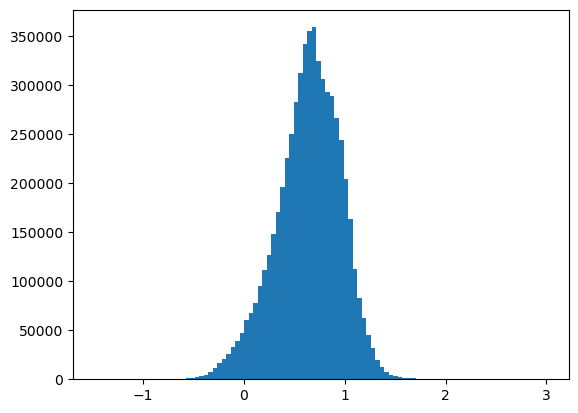

In [46]:
res= plt.hist(buoya_flat[buoya_flat<3], bins=100)
freq = res[0]/(len(buoya_flat[buoya_flat<3]))
bin_ave = 0.5*(res[1][0:-1]+res[1][1:])

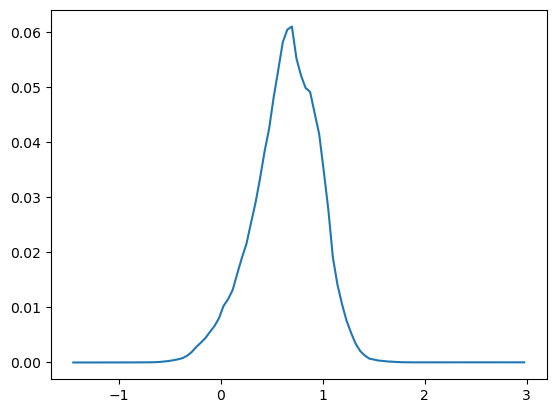

In [47]:
plt.plot(bin_ave, freq)

In [40]:
# compute anomalies daily data
s = 100

# I want ot concentrate on heat fluxes now
# whenever want to do statistics on BV
# TURN THIS TRUE
bv = False

dsst_day = np.zeros(sst_day.shape)
dbuoya_day = np.zeros(buoya.shape)
dPBLH_day = np.zeros(PBLH_day.shape)

if bv:
    dBV_freq_day = np.zeros(BV_freq.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    buoya_ave = gm.nan_gaussian_filter(buoya[t],s)                             
    dbuoya_day[t] = buoya[t] - buoya_ave
    
    pbl_ave = gm.nan_gaussian_filter(PBLH_day[t],s)                             
    dPBLH_day[t] = PBLH_day[t] - pbl_ave
    
    if bv:
        for h in range(0,BV_freq.shape[1]):
            bv_ave = gm.nan_gaussian_filter(BV_freq[t,h].magnitude,s)                               
            dBV_freq_day[t,h] = BV_freq[t,h].magnitude - bv_ave

0
10
20


In [26]:
# compute distributions

(29, 546, 573)

In [43]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [44]:
# PERC DISTRIBUTION dBV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_dBV_freq_day, pstd_dBV_freq_day, pstderr_dBV_freq_day, ppvalue_dBV_freq_day, ppvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=27, 'perc')

0
10
20
30


In [61]:
# PERC DISTRIBUTION BV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_BV_freq, pstd_BV_freq, pstderr_BV_freq, ppvalue_BV_freq, ppvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=27, 'perc')

0
10
20
30


In [ ]:
# plotting ONLY dBV or BV

In [82]:
p_level_plot = int(15)

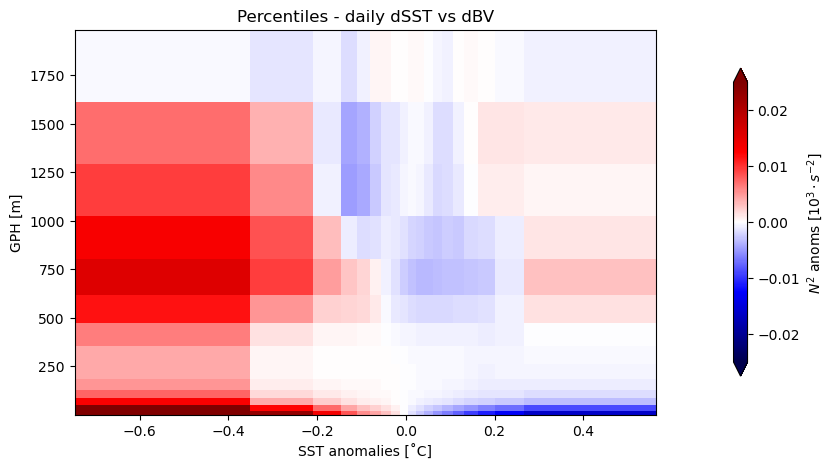

In [83]:
#pval_hatch = np.ma.masked_less(pvalue_dQVAPOR_day, 0.05)

# figure dQVAPOR vs dSST bin - DAILY
fig, ax1 = plt.subplots(figsize=(10, 5))  
p1 = ax1.pcolormesh(pdist_dsst_day, GPH_mean[0:p_level_plot], pdist_dBV_freq_day[0:p_level_plot,:]*1000, vmin=-0.025, vmax=0.025, cmap='seismic') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title('Percentiles - daily dSST vs dBV')

cbar = plt.colorbar(p1,ax=ax1, location='right', pad=0.1, shrink=0.8, extend='both')  
cbar.set_label('$N^2$ anoms [$10^3 \cdot s^{-2}$]')



# statistical (in)significance hatching
pval = ppvalue_dBV_freq_day_sub if anoms else ppvalue_BV_freq_sub
pval_hatch = np.ma.masked_greater(pval, 0.05)
plt.pcolor(pdist_dsst_day, GPH_mean[0:p_level_plot], pval_hatch, hatch='/', alpha=1.)   #, zorder=10)



#plt.savefig('/venus/tesi_ale/img_EU/QVAPOR/daily/pdist/pdist_dsst-dqvap-dpblh_day_lowtropo.png')

In [ ]:
# FIXED BIN DISTRIBUTIONS

In [102]:
# FB DISTRIBUTION dBV_freq vs dSST bin - DAILY + PVALUE subsampled

perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

dist_dsst_day, dist_dBV_freq_day, stderr_dBV_freq_day, npoint_dBV_freq_day, pvalue_dBV_freq_day, pvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=27, 'fb')


'''dist_dBV_freq_day = np.zeros((dBV_freq_day.shape[1],nbins))
npoint_dBV_freq_day = np.zeros((dBV_freq_day.shape[1],nbins))
stderr_dBV_freq_day = np.zeros((dBV_freq_day.shape[1],nbins))
pvalue_dBV_freq_day = np.zeros((dBV_freq_day.shape[1],nbins))

for h in range(0,dBV_freq_day.shape[1]):
    if h % 10 == 0:
        print(h)   
    x = dsst_day.copy(); control = x.reshape(-1)
    y = dBV_freq_day[:,h].copy(); variable = y.reshape(-1)
    
    ##### Fixed bin distribution: 
    dist_dsst_day, dist_dBV_freq_day[h], stderr_dBV_freq_day[h], npoint_dBV_freq_day[h], pv = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)
    
    ##### Fixed bin distribution: pvalue on subsampled field
    if h <= 27:
        x = dsst_day[::nt,::nskip,::nskip].copy(); control = x.reshape(-1)
        y = dBV_freq_day[::nt,h,::nskip,::nskip].copy(); variable = y.reshape(-1)
    else:
        x = dsst_day[::nttop,::nskiptop,::nskiptop].copy(); control = x.reshape(-1)
        y = dBV_freq_day[::nttop,h,::nskiptop,::nskiptop].copy(); variable = y.reshape(-1)
    dist_control, dist, stderr, npoint, pvalue_dBV_freq_day[h] = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)'''

0
10
20
30


In [104]:
# FB DISTRIBUTION BV vs dSST bin - DAILY + PVALUE subsampled
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

dist_dsst_day, dist_BV_freq, std_BV_freq, stderr_BV_freq, pvalue_BV_freq, pvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=27, 'fb')




'''dist_BV_freq = np.zeros((BV_freq.shape[1],nbins))
npoint_BV_freq = np.zeros((BV_freq.shape[1],nbins))
stderr_BV_freq = np.zeros((BV_freq.shape[1],nbins))
pvalue_BV_freq = np.zeros((BV_freq.shape[1],nbins))

for h in range(0,BV_freq.shape[1]):
    if h % 10 == 0:
        print(h)   
    x = dsst_day.copy(); control = x.reshape(-1)
    y = BV_freq[:,h].magnitude.copy(); variable = y.reshape(-1)
    
    ##### Fixed bin distribution: 
    dist_dsst_day, dist_BV_freq[h], stderr_BV_freq[h], npoint_BV_freq[h], pv = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)
    
    ##### Fixed bin distribution: pvalue on subsampled field
    if h <= 27:
        x = dsst_day[::nt,::nskip,::nskip].copy(); control = x.reshape(-1)
        y = BV_freq[::nt,h,::nskip,::nskip].magnitude.copy(); variable = y.reshape(-1)
    else:
        x = dsst_day[::nttop,::nskiptop,::nskiptop].copy(); control = x.reshape(-1)
        y = BV_freq[::nttop,h,::nskiptop,::nskiptop].magnitude.copy(); variable = y.reshape(-1)
    dist_control, dist, stderr, npoint, pvalue_BV_freq[h] = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)'''

0
10
20
30


In [ ]:
# correlations with PBLH

In [84]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [85]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask, drop=False).values;

In [86]:
dPBLH_day = np.zeros(PBLH_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    PBLH_ave = gm.nan_gaussian_filter(PBLH_day[t],s)
    dPBLH_day[t] = PBLH_day[t] - PBLH_ave

0
10
20


In [89]:
# PERC DISTRIBUTION    +   
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# dPBLH vs dSST - DAILY
pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, ppvalue_dPBLH_day = \
distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'perc')

# dSST vs PBLH 
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, nbins, perc_step, popmean, 'perc')

'''pdist_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
pstd_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
pstderr_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
pvalue_dPBLH_day_sub = np.zeros((dPBLH_day.shape[1],nbins))
pvalue_dPBLH_day = np.zeros_like(pvalue_dPBLH_day_sub)

 
x = dsst_day.copy(); control = x.reshape(-1)
y = dPBLH_day.copy(); variable = y.reshape(-1)
    
##### Perc bin distribution: pvalue
pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, pvalue_dPBLH_day = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)

'''

'''#### # PERC DISTRIBUTION PBLH vs dSST - DAILY 
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day.copy()
variable = y.reshape(-1)
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, pvalue_PBLH_dsst = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)

'''

In [105]:
# FB DISTRIBUTION dPBLH vs dSST bin - DAILY 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.


# dPBLH vs dSST - DAILY
dist_dsst_day, dist_dPBLH_day, std_dPBLH_day, stderr_dPBLH_day, pvalue_dPBLH_day = \
distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'fb')

# dSST vs PBLH 
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, pvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, nbins, perc_step, popmean, 'fb')



'''dist_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
std_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
stderr_dPBLH_day = np.zeros((dPBLH_day.shape[1],nbins))
pvalue_dPBLH_day = np.zeros_like(pvalue_dPBLH_day_sub)

 
x = dsst_day.copy(); control = x.reshape(-1)
y = dPBLH_day.copy(); variable = y.reshape(-1)
    
##### Perc bin distribution: pvalue
dist_dsst_day, dist_dPBLH_day, std_dPBLH_day, stderr_dPBLH_day, pvalue_dPBLH_day = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)



#### # PERC DISTRIBUTION PBLH vs dSST bin - DAILY 
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day.copy()
variable = y.reshape(-1)
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, pvalue_PBLH_dsst = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)
'''

Text(0.4, 755, 'PBLH')

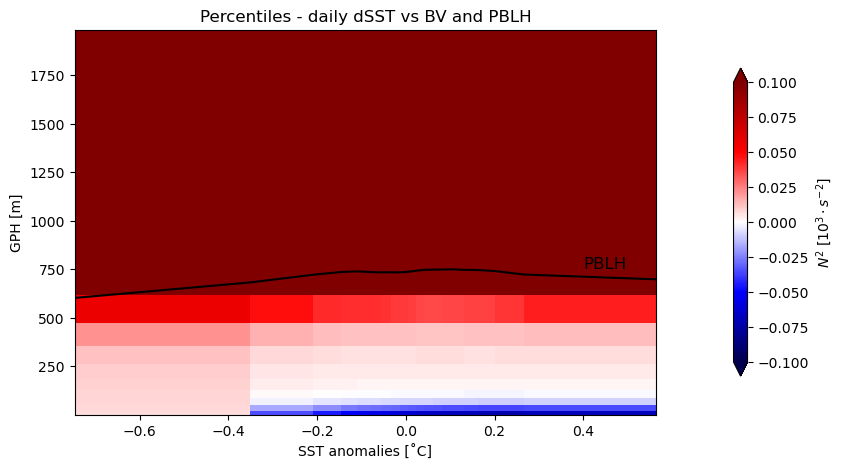

In [101]:
# figure dBV or BV vs dSST bin - DAILY
anoms = False
var = pdist_dBV_freq_day[0:p_level_plot,:]*1000 if anoms else pdist_BV_freq[0:p_level_plot,:]*1000
minval = -0.025 if anoms else -0.1
maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  
p1 = ax1.pcolormesh(pdist_dsst_day, GPH_mean[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title('Percentiles - daily dSST vs BV and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', pad=0.1, shrink=0.8, extend='both')  
cbar.set_label('$N^2$ [$10^3 \cdot s^{-2}$]')

ax1.plot(pdist_dsst, pdist_PBLH_dsst, 'k')
ax1.text(0.4, 755, 'PBLH', fontsize=12)



# statistical significance hatching
pval = ppvalue_dBV_freq_day_sub if anoms else ppvalue_BV_freq_sub
pval_hatch = np.ma.masked_greater(pval, 0.05)
plt.pcolor(pdist_dsst_day, GPH_mean[0:p_level_plot], pval_hatch, hatch='/', alpha=1.)   #, zorder=10)



#plt.savefig('/venus/tesi_ale/img_EU/BV/daily/distrib/perc/pdist_dsst-fullBV-PBLH_lowtropo.png')


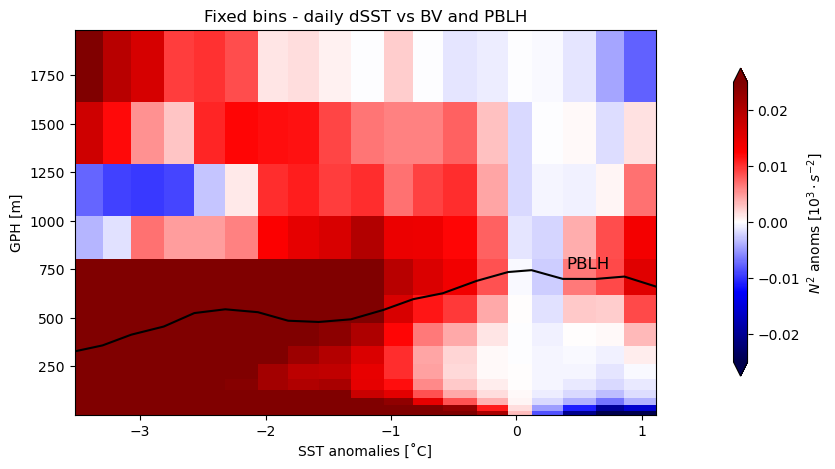

In [109]:
# figure dBV or BV vs dSST bin - DAILY
anoms = True
var = dist_dBV_freq_day[0:p_level_plot,:]*1000 if anoms else dist_BV_freq[0:p_level_plot,:]*1000
minval = -0.025 if anoms else -0.1
maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  
p1 = ax1.pcolormesh(dist_dsst_day, GPH_mean[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title('Fixed bins - daily dSST vs BV and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', pad=0.1, shrink=0.8, extend='both')  
cbar.set_label('$N^2$ anoms [$10^3 \cdot s^{-2}$]')

ax1.plot(dist_dsst, dist_PBLH_dsst, 'k')
ax1.text(0.4, 755, 'PBLH', fontsize=12)


# statistical significance hatching
pval = pvalue_dBV_freq_day_sub if anoms else pvalue_BV_freq_sub
pval_hatch = np.ma.masked_greater(pvalue_dQVAPOR_day, 0.05)
plt.pcolor(pdist_dsst_day, GPH_mean[0:p_level_plot], pval_hatch, hatch='/', alpha=1.)   #, zorder=10)


#plt.savefig('/venus/tesi_ale/img_EU/BV/daily/distrib/fix_bin/bin_dsst-dBV-PBLH_lowtropo.png')


In [ ]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [8]:
LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values; 

HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
HFX = HFX.where(sea_mask, drop=False).values; 

In [14]:
# this should be the Bowen ratio at the surface
heat_ratio = LH/HFX
heat_ratio[HFX==0] = 999.

In [ ]:
# heat anomalies

In [9]:
s = 100

dLH = np.zeros(LH.shape)
dHFX = np.zeros(HFX.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave
    
    HFX_ave = gm.nan_gaussian_filter(HFX[t],s)                             
    dHFX[t] = HFX[t] - HFX_ave

0
10
20


In [ ]:
# DISTRIBUTIONS

In [23]:
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [ ]:
# dSST vs dLH / dHFX vs PBLH

In [25]:
# I want to build distributions for 
# dsst and dbuoya
# without taking up too much space

dsst_bool = True
x = dsst_day if dsst_bool else dbuoya_day

In [27]:
# dSST vs dLH
pdist_x, pdist_dLH, pstd_dLH, pstderr_dLH, pnpoints_dLH, ppvalue_dLH =   distrib_2d(x, dLH, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dLH, std_dLH, stderr_dLH, npoints_dLH, pvalue_dLH       =   distrib_2d(x, dLH, perc_step, nbins, popmean, perc_fixbin='fb')

In [33]:
# dSST vs dHFX
pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(x, dHFX, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dHFX, std_dHFX, stderr_dHFX, npoints_dHFX, pvalue_dHFX       =   distrib_2d(x, dHFX, perc_step, nbins, popmean, perc_fixbin='fb')

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(x, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(x, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [47]:
# the last, highest dSST / dLH bin
# is actually one of the most populated

npoints_dPBLH

array([1.700000e+01, 3.600000e+01, 6.100000e+01, 9.600000e+01,
       1.420000e+02, 2.000000e+02, 5.370000e+02, 1.114000e+03,
       1.996000e+03, 3.993000e+03, 3.068900e+04, 9.682400e+04,
       1.726550e+05, 3.833020e+05, 2.467399e+06, 2.335781e+06,
       2.541170e+05, 9.289500e+04, 4.131900e+04, 7.161000e+03])

In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

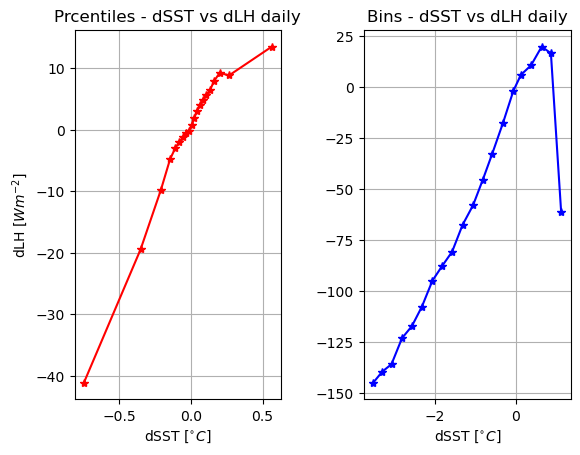

In [32]:
# dist_x vs dLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_x, pdist_dLH, '*-r')
ax1.set_xlabel('dSST [$^{\circ}C$]')
ax1.set_ylabel('dLH [$Wm^{-2}$]')
ax1.set_title('Percentiles - dSST vs dLH daily'); ax1.grid()

p2 = ax2.plot(dist_x, dist_dLH, '*-b')
ax2.set_xlabel('dSST [$^{\circ}C$]')
ax2.set_title('Bins - dSST vs dLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

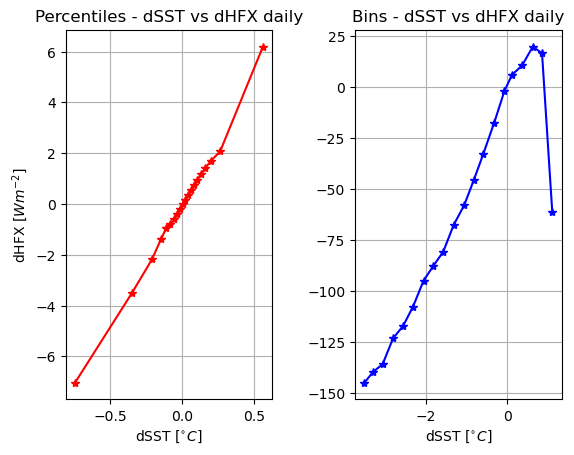

In [34]:
# dist_x vs dHFX

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_x, pdist_dHFX, '*-r')
ax1.set_xlabel('dSST [$^{\circ}C$]')
ax1.set_ylabel('dHFX [$Wm^{-2}$]')
ax1.set_title('Percentiles - dSST vs dHFX daily'); ax1.grid()

p2 = ax2.plot(dist_x, dist_dLH, '*-b')
ax2.set_xlabel('dSST [$^{\circ}C$]')
ax2.set_title('Bins - dSST vs dHFX daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

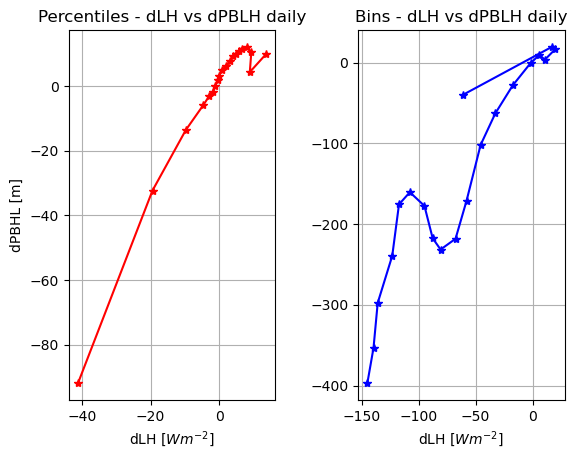

In [43]:
# dLH vs dPBLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_dLH, pdist_dPBLH, '*-r')
ax1.set_xlabel('dLH [$Wm^{-2}$]')
ax1.set_ylabel('dPBHL [m]')
ax1.set_title('Percentiles - dLH vs dPBLH daily'); ax1.grid()

p2 = ax2.plot(dist_dLH, dist_dPBLH, '*-b')
ax2.set_xlabel('dLH [$Wm^{-2}$]')
ax2.set_title('Bins - dLH vs dPBLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

In [ ]:
#### DISTRIBUTIONS  HF  vs   DIV_U?